<a href="https://colab.research.google.com/github/wnozawa/stockprice/blob/main/EarningSurpriseEffect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

by Wataru Nozawa

Version: November 4, 2021

# Introduction

**Question：**　Buying after earning surprise is profitable?

This code calculates the time series of stock returns after earnings announcements for each size of earnings surprise, etc.

# Memo

*   Check effect of earnings surprise on stock returns
*   Which stocks?
*   Which dates? Get announcement datetime data, then get price data
*   result for various time spans: 1min, 10min, 30min, 1hour, 1day, 1week
*   Make list of stock symbols

# Code description


1.   get annoucement date-time data
  *    create dataframe of (ticker symbol, annoucement date-time) entries
2.   get stock price data around announcements. compute returns
  *    for each entry of the dataframe in 1, download stock price after 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo (see module decsription for yfinance: https://pypi.org/project/yfinance/)
  *    compute returns as (price at each moment)/(price 1 min later than annoucement)
  *    if annoucement is released in closed time, 1min later than annoucement = 1min later than opening
3.   download earnings surprise data
1.   categorize stocks by surprise size into top-30%, bottom-30%, and middle
  *    create dataframe which has surprise size categories for columns and stocks for rows. Each entry = 1 if the stock is in the category and 0 if not
1.   compute and draw average returns for each surprise size category
1.   draw figures



# Code

0. preamble

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 18.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=4701421740524adbefb1fc2533781528d1da3d8e031b81d7ba55c2cbc5b19d9f
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd

## 1.   get annoucement date-time data
  *    download annoucement date-time data from my drive
  *    create dataframe of (ticker symbol, annoucement date-time) entries

In [ ]:
# download annoucement date-time data from my drive
annoucement_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTqbLMJMvwyPl_9Rv6g_apziytXTZ19R0t6PzH1X0p7aL6NmlGojP9OBvDeF-X555iL948L-pZ2Xwfy/pub?output=csv'
df_an_raw = pd.read_csv(annoucement_url)

# create dataframe of (ticker symbol, annoucement date-time) entries
# combine 発表日 & 発表時刻, and convert it from string to datetime
temp_date = pd.to_datetime(df_an_raw['発表日'] + ' ' + df_an_raw['発表\n時刻'].str[:5])
df_an = pd.DataFrame({"datetime": temp_date,
                      "ticker": df_an_raw['ティッカー'],
                      "quarter": df_an_raw['種別']})

In [ ]:
# check the outcome
df_an

,datetime,ticker,quarter
0,2021-09-01 07:23:00,CPB,4Q
1,2021-09-01 16:05:00,NTNX,4Q
2,2021-09-01 16:05:00,OKTA,2Q
3,2021-09-01 16:06:00,SWBI,1Q
4,2021-09-01 16:06:00,VEEV,2Q
...,...,...,...
360,2021-10-28 17:00:00,BIO,3Q
361,2021-10-28 17:00:00,CVA,3Q
362,2021-10-28 17:00:00,EMN,3Q
363,2021-10-28 17:00:00,X,3Q


## 2.   get stock price data around announcements. compute returns
  *    for each entry of the dataframe in 1, download stock price after 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo (see module decsription for yfinance: https://pypi.org/project/yfinance/)
      *    if annoucement is released in closed time, 1min later than annoucement = 1min later than opening
  *    compute returns as (price at each moment)/(price 1 min later than annoucement)


In [ ]:
# length_of_df_an = len(df_an)
# length_of_df_an

365

In [ ]:
# get today's datetime
import datetime
# today = datetime.today()
now = datetime.datetime.now()
# today

one_week = datetime.timedelta(weeks=1)
one_week_ago = now - one_week
# one_week_ago

datetime.datetime(2021, 10, 27, 11, 26, 3, 166091)

In [ ]:
# drop entries that are after (today - 1 week) in df_an 
df_an_1w = df_an[df_an['datetime'] < one_week_ago]
# df_an_1w

# drop_enxtries before 60 days 
fourty_days = datetime.timedelta(days=39)
fourty_days_ago = now - fourty_days
df_an_40d_1w = df_an_1w[df_an_1w['datetime'] >= fourty_days_ago]
df_an_40d_1w = df_an_40d_1w.reset_index()
# df_an_40d_1w.iloc[5]

index                        47
datetime    2021-10-04 16:22:00
ticker                     NAPA
quarter                      4Q
Name: 5, dtype: object

In [ ]:
# for each stock in df_an_1w, get stock price data from yahoo finance
import yfinance as yf

length_of_df_an_40d_1w = len(df_an_40d_1w)

close_time = datetime.time(16, 00, 00, 0000)

small_dfs = []
for i in range(length_of_df_an_40d_1w):
    # for i in range(3):
    index, an_datetime, ticker, quarter = df_an_40d_1w.loc[i]
    # set data starting date;
    # if annoucement < 16:00, it's just datetime
    # if annoucement >= 16:00, it,s datetime + 1 day
    start_datetime = an_datetime
    if start_datetime.time() >= close_time:
        start_datetime = start_datetime + datetime.timedelta(days=1)
    
#    print([an_datetime, start_datetime])
    starting_date = str(start_datetime.date())
    ending_date = str(start_datetime.date() + datetime.timedelta(days=5))
    print(starting_date)
    data = yf.download(tickers=ticker,
                       interval='2m',
                       auto_adjust=True,
                       prepost=False,
                       start=starting_date,
                       end=ending_date)
    
    ticker_col = [ticker] * len(data)
    data['ticker'] = ticker_col

    small_dfs.append(data)

large_df = pd.concat(small_dfs, ignore_index=False)


2021-09-30
[*********************100%***********************]  1 of 1 completed
2021-09-30
[*********************100%***********************]  1 of 1 completed
2021-09-30
[*********************100%***********************]  1 of 1 completed
2021-09-30
[*********************100%***********************]  1 of 1 completed
2021-10-01
[*********************100%***********************]  1 of 1 completed
2021-10-05
[*********************100%***********************]  1 of 1 completed
2021-10-06
[*********************100%***********************]  1 of 1 completed
2021-10-07
[*********************100%***********************]  1 of 1 completed
2021-10-07
[*********************100%***********************]  1 of 1 completed
2021-10-07
[*********************100%***********************]  1 of 1 completed
2021-10-07
[*********************100%***********************]  1 of 1 completed
2021-10-12
[*********************100%***********************]  1 of 1 completed
2021-10-13
[*********************100%***

In [ ]:
# print(data.iloc[1:30])
# print(data)
# why 2021-9-20??? 

In [ ]:
large_df = pd.concat(small_dfs, ignore_index=False)

large_df

,Open,High,Low,Close,Volume,ticker
Datetime,,,,,,
2021-09-30 09:30:00-04:00,133.210007,133.210007,131.080002,132.490005,228210.0,KMX
2021-09-30 09:32:00-04:00,133.380005,133.660004,133.380005,133.660004,322.0,KMX
2021-09-30 09:34:00-04:00,133.460007,133.460007,131.600006,132.580002,32080.0,KMX
2021-09-30 09:36:00-04:00,132.320007,133.919998,131.750000,133.919998,19450.0,KMX
2021-09-30 09:38:00-04:00,133.490005,133.919998,132.350006,133.455002,174999.0,KMX
...,...,...,...,...,...,...
2021-10-29 15:50:00-04:00,76.690002,76.790001,76.681000,76.779999,33597.0,APH
2021-10-29 15:52:00-04:00,76.769997,76.785004,76.735001,76.754997,27127.0,APH
2021-10-29 15:54:00-04:00,76.760002,76.820000,76.745003,76.800003,50363.0,APH


In [ ]:
large_df[large_df['ticker']=='PNC']

,Open,High,Low,Close,Volume,ticker
Datetime,,,,,,
2021-10-14 09:30:00-04:00,NaN,NaN,NaN,NaN,NaN,PNC
2021-10-15 09:30:00-04:00,195.619995,197.199997,195.380005,196.895004,335463.0,PNC
2021-10-15 09:32:00-04:00,196.919998,197.610001,196.919998,197.360001,29206.0,PNC
2021-10-15 09:34:00-04:00,197.300003,197.970001,196.800003,197.970001,55411.0,PNC
2021-10-15 09:36:00-04:00,197.854996,198.380005,197.770004,197.770004,43187.0,PNC
...,...,...,...,...,...,...
2021-10-19 15:50:00-04:00,206.009995,206.220001,205.990005,206.130005,29912.0,PNC
2021-10-19 15:52:00-04:00,206.139999,206.229996,206.119995,206.210007,22080.0,PNC
2021-10-19 15:54:00-04:00,206.205002,206.660004,206.190002,206.660004,53035.0,PNC


In [ ]:
# test_data = large_df.reset_index(level=['Datetime']).set_index(['ticker'], append=True)
test_data = large_df.reset_index(level=['Datetime'])
test_data

,Datetime,Open,High,Low,Close,Volume,ticker
0,2021-09-30 09:30:00-04:00,133.210007,133.210007,131.080002,132.490005,228210.0,KMX
1,2021-09-30 09:32:00-04:00,133.380005,133.660004,133.380005,133.660004,322.0,KMX
2,2021-09-30 09:34:00-04:00,133.460007,133.460007,131.600006,132.580002,32080.0,KMX
3,2021-09-30 09:36:00-04:00,132.320007,133.919998,131.750000,133.919998,19450.0,KMX
4,2021-09-30 09:38:00-04:00,133.490005,133.919998,132.350006,133.455002,174999.0,KMX
...,...,...,...,...,...,...,...
132935,2021-10-29 15:50:00-04:00,76.690002,76.790001,76.681000,76.779999,33597.0,APH
132936,2021-10-29 15:52:00-04:00,76.769997,76.785004,76.735001,76.754997,27127.0,APH
132937,2021-10-29 15:54:00-04:00,76.760002,76.820000,76.745003,76.800003,50363.0,APH
132938,2021-10-29 15:56:00-04:00,76.800003,76.845001,76.760002,76.839996,43605.0,APH


In [ ]:
test_data[test_data['ticker']=='PNC']['Datetime'].iloc[0].weekday()

3

In [ ]:
ticker_list = list(large_df['ticker'].unique())

open_time = datetime.time(9, 30, 00, 0000)

ticker_dfs = []
for ticker in ticker_list:
    an_datetime = df_an[df_an['ticker']==ticker]['datetime']

    
    df = test_data[test_data['ticker']==ticker]
    df = df.reset_index()
    df['Return'] = df['Close']/df['Close'][0] - 1

    ticker_dfs.append(df)

df_returns = pd.concat(ticker_dfs, ignore_index=True)


In [ ]:
#open_time = datetime.time( 16, 00, 00, 0000)
close_time = datetime.time( 16, 00, 00, 0000)

minutes_list = [0, 2, 10, 20, 30, 60, 120, 240]
# ticker = 'BBBY'
ticker_return_list =[]
nodata_list = []
for ticker in ticker_list:
    print(ticker)
    df_ticker_return = df_returns[df_returns['ticker']==ticker].reset_index()
    df_ticker_return['Datetime'][0]
    t_0min = df_ticker_return['Datetime'][0]

    return_list = []
    for minute in minutes_list:
        flag_nodata = 0
        t_min = t_0min + datetime.timedelta(minutes=minute)
#        print(t_min)
        return_t_min = df_ticker_return['Return'][df_ticker_return['Datetime'] == t_min]
#        print(type(return_t_min))
        #if type(return_t_min)==.core.series.Series:
        #    return_t_min = return_t_min.reset_index()
        #    ret = float(return_t_min[0])
        #else:
        if len(return_t_min) > 0:
            ret = float(return_t_min.iloc[0])
        else:
            flag_nodata = 1
            ret = 0
        return_list.append(ret)

    if flag_nodata == 0:
        ticker_return_list.append(return_list)
    else:
        nodata_list.append(ticker)


# df_returns['Return'][df_returns['Datetime'] == t_2min & df_returns['ticker']==ticker]


In [ ]:
ticker_list = list(large_df['ticker'].unique())
ticker_list = [ticker for ticker in ticker_list if ticker not in nodata_list]

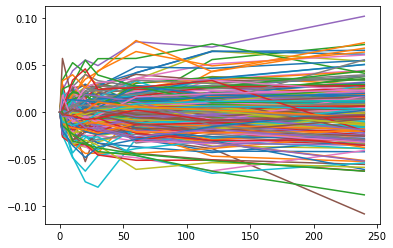

In [ ]:

df_TR = pd.DataFrame(ticker_return_list, index=ticker_list, columns=minutes_list)
df_TR.T.plot(legend=False)

In [ ]:
# str(minutes_list)
index_minutes = [ str(x) for x in minutes_list ]
index_minutes

df_TR = pd.DataFrame(ticker_return_list, index=ticker_list, columns=index_minutes)
df_TR.T.plot()


In [ ]:
df_TR

,0,2,10,20,30,60,120,240,1440
KMX,0.0,0.008831,0.024794,0.002679,-0.003321,-0.012680,-0.018341,-0.012001,-0.029587
MKC,0.0,0.006278,0.012414,0.019409,0.019163,0.017353,0.013142,0.005174,-0.007098
BBBY,0.0,-0.005252,0.024405,0.008965,0.026877,0.008959,0.055694,0.071634,0.072289


## 3.   download earnings surprise data

In [ ]:
BASE_URL = "https://www.alphavantage.co/query?"
API_KEY = "503ASZ7L62YPUYNY"

In [ ]:
import requests

def earnings_history_api(api_key, symbol):
    assert symbol is not None
    symbol = symbol.strip().upper()

    url = f"{BASE_URL}function=EARNINGS&symbol={symbol}&apikey={api_key}"

    response = requests.get(url)

    return pd.DataFrame(response.json()['quarterlyEarnings'])

In [ ]:
# ticker_list.remove('JEF')  # NAPA leads to error in alpha vantage data download
len(ticker_list)
import time
# time.sleep(60)

KeyboardInterrupt: ignored

In [ ]:
surprisep_list = []
no_surp_data_list = []
for ticker in ticker_list:
# ticker = 'BBBY'
    an_datetime = df_an[df_an['ticker']==ticker]['datetime']
    print(ticker)
    earnings_history = earnings_history_api(API_KEY, ticker)
# earnings_history['reportedDate']
    surprisep = earnings_history[earnings_history['reportedDate']==str(an_datetime.iloc[0].date())]['surprisePercentage']
    print(surprisep)
    if len(surprisep) > 0:
        surprisep_list.append(surprisep.iloc[0])
    else:
        no_surp_data_list.append(ticker)
    time.sleep(12)

KMX
0    -8.8452
Name: surprisePercentage, dtype: object
MKC
0    10.9416
Name: surprisePercentage, dtype: object
BBBY
0    -92.3136
Name: surprisePercentage, dtype: object
PAYX
0    10.862
Name: surprisePercentage, dtype: object
JEF
1    49.2537
Name: surprisePercentage, dtype: object
NAPA
0    422.8758
Name: surprisePercentage, dtype: object
STZ
0    -13.8524
Name: surprisePercentage, dtype: object
LEVI
0    28.0341
Name: surprisePercentage, dtype: object
TLRY
0    69.5652
Name: surprisePercentage, dtype: object
CAG
0    3.1779
Name: surprisePercentage, dtype: object
LW
0    -47.2296
Name: surprisePercentage, dtype: object
FAST
0    1.083
Name: surprisePercentage, dtype: object
JPM
0    18.3097
Name: surprisePercentage, dtype: object
DAL
0    96.4637
Name: surprisePercentage, dtype: object
BLK
0    15.1625
Name: surprisePercentage, dtype: object
UNH
0    2.3504
Name: surprisePercentage, dtype: object
USB
0    12.4178
Name: surprisePercentage, dtype: object
BAC
0    21.6023
Name: surp

In [ ]:
# surprisep.iloc[0]
# str(an_datetime.iloc[0].date())
ticker_list = [ticker for ticker in ticker_list if ticker not in no_surp_data_list]

In [ ]:
earnings_history


,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage
0,2021-09-30,2021-10-26,0.52,0.5436,-0.0236,-4.3414
1,2021-06-30,2021-07-26,0.24,0.2472,-0.0072,-2.9126
2,2021-03-31,2021-04-26,0.3,0.2259,0.0741,32.8021
3,2020-12-31,2021-02-23,0.02,0.0566,-0.0366,-64.6643
4,2020-09-30,2020-10-29,-0.05,-0.0199,-0.0301,-151.2563
...,...,...,...,...,...,...
98,1997-03-31,1997-05-13,0.23,0.23,0,0
99,1996-12-31,1997-02-06,0.17,0.13,0.04,30.7692
100,1996-09-30,1996-11-07,0.09,0.1,-0.01,-10
101,1996-06-30,1996-08-08,0.1,0.1,0,0


In [ ]:
df_surprisep = pd.DataFrame(surprisep_list, index=ticker_list, columns=['surprisePercentage'])

In [ ]:
ticker_list
surprisep
df_surprisep
# earnings_history

,surprisePercentage
KMX,-8.8452
MKC,10.9416
BBBY,-92.3136
PAYX,10.862
JEF,49.2537
...,...
NSC,4.9491
ROL,-5.9406
GM,57.0572
BMY,4.259


## 4.   categorize stocks by surprise size into top-30%, bottom-30%, and middle
  *    create dataframe which has surprise size categories for columns and stocks for rows. Each entry = 1 if the stock is in the category and 0 if not

In [ ]:
surp_category_list = []

for ticker in ticker_list:
    surp = float(df_surprisep.loc[ticker]['surprisePercentage'])
    if surp < -10.0:
        surp_category_list.append(-1)
    elif surp > 10.0:
        surp_category_list.append(1)
    else:
        surp_category_list.append(0)

# some_var = [expression for item in iterable_obj if condition]

df_surprisep['category'] = surp_category_list

## 5.   compute average returns for each surprise size category


In [ ]:
df_surprisep

,surprisePercentage,category
KMX,-8.8452,0
MKC,10.9416,1
BBBY,-92.3136,-1
PAYX,10.862,1
JEF,49.2537,1
...,...,...
NSC,4.9491,0
ROL,-5.9406,0
GM,57.0572,1
BMY,4.259,0


In [ ]:
df_surprisep['surprisePercentage']std()

TypeError: ignored

In [ ]:
df_TR_d = df_TR.drop(no_surp_data_list)

In [ ]:
average_return_dfs = []
average_return_dfs.append(pd.DataFrame(df_TR_d[df_surprisep['category']==1].mean()))
average_return_dfs.append(pd.DataFrame(df_TR_d[df_surprisep['category']==0].mean()))
average_return_dfs.append(pd.DataFrame(df_TR_d[df_surprisep['category']==-1].mean()))

df_average_returns = pd.concat(average_return_dfs, axis=1, ignore_index=False)


In [ ]:
df_average_returns = df_average_returns.set_axis(['good', 'expected', 'bad'], axis='columns')

## 6.   draw figures


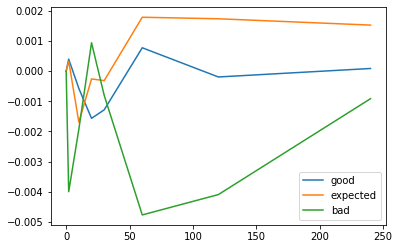

In [ ]:
df_average_returns.plot()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_average_returns.to_csv('/content/drive/MyDrive/df_average_returns.csv')
df_surprisep.to_csv('/content/drive/MyDrive/df_surprisep.csv')
df_TR.to_csv('/content/drive/MyDrive/df_TR.csv')
test_data.to_csv('/content/drive/MyDrive/test_data.csv')

# read this to restart

## Restart

In [1]:
# read csvs
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_average_returns = pd.read_csv('/content/drive/MyDrive/df_average_returns.csv')
df_surprisep = pd.read_csv('/content/drive/MyDrive/df_surprisep.csv')
df_TR = pd.read_csv('/content/drive/MyDrive/df_TR.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test_data.csv')

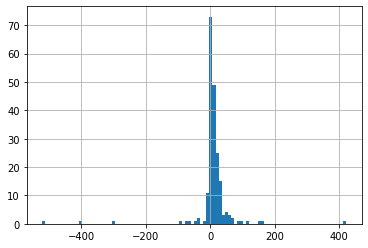

In [51]:
df_surprisep['surprisePercentage'].hist(bins=100)

In [6]:
ticker_list = list(df_surprisep['Unnamed: 0'].unique())

df_surprisep = df_surprisep.set_index('Unnamed: 0')
df_TR = df_TR.set_index('Unnamed: 0')
mu, sig = [df_surprisep['surprisePercentage'].mean(), df_surprisep['surprisePercentage'].std()]

In [7]:
# ticker_list = [ticker for ticker in ticker_list if ticker not in nodata_list]
df_TR_d = df_TR.loc[ticker_list]

In [44]:
surp_category_list = []

for ticker in ticker_list:
    surp = float(df_surprisep.loc[ticker]['surprisePercentage'])
    if surp < -5:
        surp_category_list.append(-1)
    elif surp > 30:
        surp_category_list.append(1)
    else:
        surp_category_list.append(0)

# some_var = [expression for item in iterable_obj if condition]

df_surprisep['category'] = surp_category_list

In [45]:
average_return_dfs = []
average_return_dfs.append(pd.DataFrame(df_TR_d[df_surprisep['category']==1].mean()))
average_return_dfs.append(pd.DataFrame(df_TR_d[df_surprisep['category']==0].mean()))
average_return_dfs.append(pd.DataFrame(df_TR_d[df_surprisep['category']==-1].mean()))

df_average_returns = pd.concat(average_return_dfs, axis=1, ignore_index=False)

In [46]:
df_average_returns = df_average_returns.set_axis(['good', 'expected', 'bad'], axis='columns')

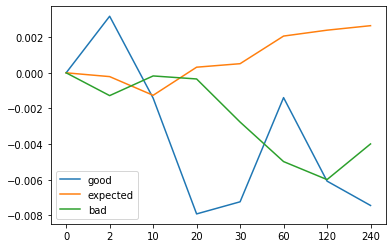

In [47]:
df_average_returns.plot()

In [11]:
import plotly.express as px


In [13]:
df_average_returns

,good,expected,bad
0,0.000000,0.000000,0.000000
2,0.000226,0.000303,-0.005580
10,-0.005452,-0.001081,-0.000004
20,-0.022800,-0.000175,0.001118
30,-0.021022,-0.000157,-0.000844
60,-0.008854,0.001551,-0.008169
120,-0.020420,0.001389,-0.006438
240,-0.032473,0.001952,-0.005145


In [15]:
fig = px.line(df_average_returns, x=df_average_returns.index, y=['good', 'bad'])
fig.show()

ValueError: ignored

In [42]:
df_average_returns_reset = df_average_returns.reset_index()
df_average_returns_reset

df_melt = df_average_returns_reset.melt(id_vars='index')
df_melt

,index,variable,value
0,0,good,0.000000
1,2,good,0.000226
2,10,good,-0.005452
3,20,good,-0.022800
4,30,good,-0.021022
5,60,good,-0.008854
6,120,good,-0.020420
7,240,good,-0.032473
8,0,expected,0.000000
9,2,expected,0.000303


In [43]:
fig = px.line(df_melt, x='index', y='value', color='variable')
fig.show()